In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#thomas left a comment here

Mounted at /content/drive


In [ ]:
# Importing the necessary lib
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,MaxPool2D,Embedding,Dense,Dropout,MaxPooling2D,Reshape,BatchNormalization
from keras.models import Sequential
from keras import Model,Input
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Conv1D
import keras.backend as k
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,f1_score,log_loss,recall_score,classification_report
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
from time import time
from scipy.sparse import hstack
from tensorflow.python.keras.callbacks import TensorBoard
import pickle
from keras.optimizers import Adam,SGD,RMSprop
from keras.initializers import RandomUniform,he_uniform,glorot_normal
from keras.regularizers import l1
from keras.models import Sequential
from keras.layers import LSTM,BatchNormalization
from tensorflow.keras.layers import Dense, Dropout
import datetime
from prettytable import PrettyTable
from hyperopt import Trials, STATUS_OK, tpe
!pip install hyperas
from hyperas import optim
from hyperas.distributions import choice, uniform,pchoice
from keras.utils import to_categorical
from keras.regularizers import l1
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.1 MB/s eta 0:00:00


In [ ]:
#Reading the train, test and CV data
train = pd.read_csv('/content/drive/MyDrive/TEP Dataset/train.csv')
cv = pd.read_csv("/content/drive/MyDrive/TEP Dataset/cv.csv")
test = pd.read_csv("/content/drive/MyDrive/TEP Dataset/test.csv")
train.head()
print(train.shape)

(260000, 56)


In [ ]:
# # Removing faults 3, 5, 8, 9, 10, 12, 15, 16, and 18.
# tr = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15) | (train.faultNumber == 5) | (train.faultNumber == 8) | (train.faultNumber == 10) | (train.faultNumber == 12) | (train.faultNumber == 16) | (train.faultNumber == 18)].index).reset_index()
# ts = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15) | (test.faultNumber == 5) | (test.faultNumber == 8) | (test.faultNumber == 10) | (test.faultNumber == 12) | (test.faultNumber == 16) | (test.faultNumber == 18)].index).reset_index()
# cv_ = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15) | (cv.faultNumber == 5) | (cv.faultNumber == 8) | (cv.faultNumber == 10) | (cv.faultNumber == 12) | (cv.faultNumber == 16) | (cv.faultNumber == 18)].index).reset_index()

In [ ]:
#########Dataset with More faults##########

In [ ]:
# Removing faults 3, 9, and 15
tr = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15)].index).reset_index()
ts = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15)].index).reset_index()
cv_ = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15)].index).reset_index()

In [ ]:
# Map fault numbers to a new continuous range
mapping = {0:0, 1:1, 2:2, 4:3, 5:4, 6:5, 7:6, 8:7, 10:8, 11:9, 12:10, 13:11, 14:12, 16:13, 17:14, 18:15, 19:16, 20:17}
tr['mappedFaultNumber'] = tr['faultNumber'].map(mapping)
ts['mappedFaultNumber'] = ts['faultNumber'].map(mapping)
cv_['mappedFaultNumber'] = cv_['faultNumber'].map(mapping)

In [ ]:
 # Column names to drop
columns_to_drop = tr.columns[27:46]

# Drop the columns from the dataframes
tr.drop(columns_to_drop, axis=1, inplace=True)
ts.drop(columns_to_drop, axis=1, inplace=True)
cv_.drop(columns_to_drop, axis=1, inplace=True)


In [ ]:


def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_train = []
Y_train = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 18):  # Iterating correctly from 0 to 17
    max_runs = 40 if j == 0 else 25  # Assuming faultNumber 0 is fault-free
    for i in range(1, max_runs + 1):  # Iterate over the correct number of simulation runs
        df = tr[(tr['mappedFaultNumber'] == j) & (tr['simulationRun'] == i)]
        x_temp, y_temp = SlidingWindow(df, w, s)
        X_train.extend(x_temp)
        Y_train.extend(y_temp)

# Convert X and Y to numpy arrays and reshape X for LSTM
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train = X_train.reshape(-1, w, X_train.shape[-1])

X_train.shape, Y_train.shape


((21935, 20, 33), (21935,))

In [ ]:
# Initialize a StandardScaler object
sc = StandardScaler()

# Filter the DataFrame to only include data from the first simulation run
reduced_data = tr[tr['faultNumber']==0]
# Select the rows from the reduced dataset that have faultNumber equal to 0, and extract the feature values
fault_free = reduced_data[(reduced_data['faultNumber'] == 0)].iloc[:, 5:-1]

# Fit the StandardScaler object to the feature values of the fault-free data
sc.fit(fault_free)

StandardScaler()

In [ ]:
X_train_sc = sc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, Dense, LSTM,Conv2D,Conv1D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Dropout,Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Input

In [ ]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc.fit(Y_train.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_train_enc = enc.transform(Y_train.reshape(-1, 1))

In [ ]:
Y_train_enc.shape

(21935, 18)

In [ ]:
## Now Prepare CV and Test Data Set

In [ ]:

def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_test = []
Y_test = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 18):  # Iterating correctly from 0 to 17
    max_runs = 3 if j == 0 else 10  # Assuming faultNumber 0 is fault-free
    for i in range(1, max_runs + 1):  # Iterate over the correct number of simulation runs
        df = ts[(ts['mappedFaultNumber'] == j) & (ts['simulationRun'] == i)]
        x_temp, y_temp = SlidingWindow(df, w, s)
        X_test.extend(x_temp)
        Y_test.extend(y_temp)

# Convert X and Y to numpy arrays and reshape X for LSTM
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = X_test.reshape(-1, w, X_test.shape[-1])

X_test.shape, Y_test.shape


((8187, 20, 33), (8187,))

In [ ]:

def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_cv = []
Y_cv = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 18):  # Iterating correctly from 0 to 17
    if j == 0:
        max_runs = 20  # Assuming faultNumber 0 is fault-free
        for i in range(41, max_runs + 41):  # Iterate over the correct number of simulation runs
            df = cv_[(cv_['mappedFaultNumber'] == j) & (cv_['simulationRun'] == i)]
            x_temp, y_temp = SlidingWindow(df, w, s)
            X_cv.extend(x_temp)
            Y_cv.extend(y_temp)
    else:
        max_runs = 10
        for i in range(26, max_runs + 26):  # Iterate over the range 26 to max_runs
            df = cv_[(cv_['mappedFaultNumber'] == j) & (cv_['simulationRun'] == i)]
            x_temp, y_temp = SlidingWindow(df, w, s)
            X_cv.extend(x_temp)
            Y_cv.extend(y_temp)


# Convert X and Y to numpy arrays and reshape X for LSTM
X_cv = np.array(X_cv)
Y_cv = np.array(Y_cv)
X_cv = X_cv.reshape(-1, w, X_cv.shape[-1])

X_cv.shape, Y_cv.shape


((8970, 20, 33), (8970,))

In [ ]:
# print(X_cv[0,:,-1]) To verify twith the actual CSV file

In [ ]:
X_test_sc = sc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
X_cv_sc = sc.transform(X_cv.reshape(-1, X_cv.shape[-1])).reshape(X_cv.shape)

In [ ]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc_1 = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc_1.fit(Y_test.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_test_enc = enc_1.transform(Y_test.reshape(-1, 1))

In [ ]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc_2 = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc_2.fit(Y_cv.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_cv_enc = enc_2.transform(Y_cv.reshape(-1, 1))

In [ ]:
############Basic LSTM Model###########

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def build_lstm_model(X_train, y_train, num_classes):
    # Create a Sequential model
    model = Sequential()

    # Add an LSTM layer
    model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

    # Add a dropout layer for regularization
    model.add(Dropout(0.2))

    # Add another LSTM layer
    model.add(LSTM(32, activation='relu'))

    # Add a dense layer for classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 64)            25088     
                                                                 
 dropout_2 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 18)                594       
                                                                 
Total params: 38098 (148.82 KB)
Trainable params: 38098 (148.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
86/86 [==============================] - 17s 144ms/step - loss: 9.3640 - accuracy: 0.1746 - val_loss: 4.5936 - val_accuracy: 0.2852
Epoc

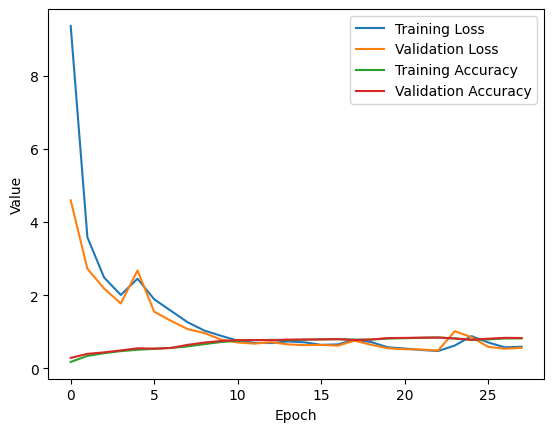

In [ ]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model_temp = build_lstm_model(X_train_sc,Y_train_enc, 18)
model_temp.summary()
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model_temp.fit(X_train_sc, Y_train_enc, epochs=200, batch_size=256, validation_data=(X_cv_sc, Y_cv_enc), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define custom class labels
custom_labels = ['0', '1', '2', '4', '5', '6', '7', '8', '10,','11', '12', '13', '14', '16', '17', '18', '19','20']

# Create a function to plot the confusion matrix with custom labels
def plot_confusion_matrix_1(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    precision = confusion_matrix(y_true, y_pred, normalize='pred')
    sns.heatmap(precision, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(precision), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    recall = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(recall, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(recall), 0)
    plt.tight_layout()
    plt.show()


    trace = np.diag(precision)

     # Sum of the trace (the sum of the diagonal elements of the confusion matrix) gives total true positives
    total_true_positives = np.sum(trace)

# Calculate the aggregate precision including class '0'
# Divide the total true positives by the number of classes
    aggregate_precision_including = total_true_positives / len(custom_labels)
    print(f"Aggregate Precision (including all classes): {aggregate_precision_including:.3f}")

# Calculate the aggregate precision excluding class '0'
# Subtract the true positives of class '0' from the total true positives and divide by the number of classes minus one
    aggregate_precision_excluding = (total_true_positives - trace[0]) / (len(custom_labels) - 1)
    print(f"Aggregate Precision (excluding class '0'): {aggregate_precision_excluding:.3f}")


In [ ]:
y_pred = enc_1.inverse_transform(model_temp.predict(X_test_sc, verbose=0))

In [ ]:
y_true = enc_1.inverse_transform(Y_test_enc)

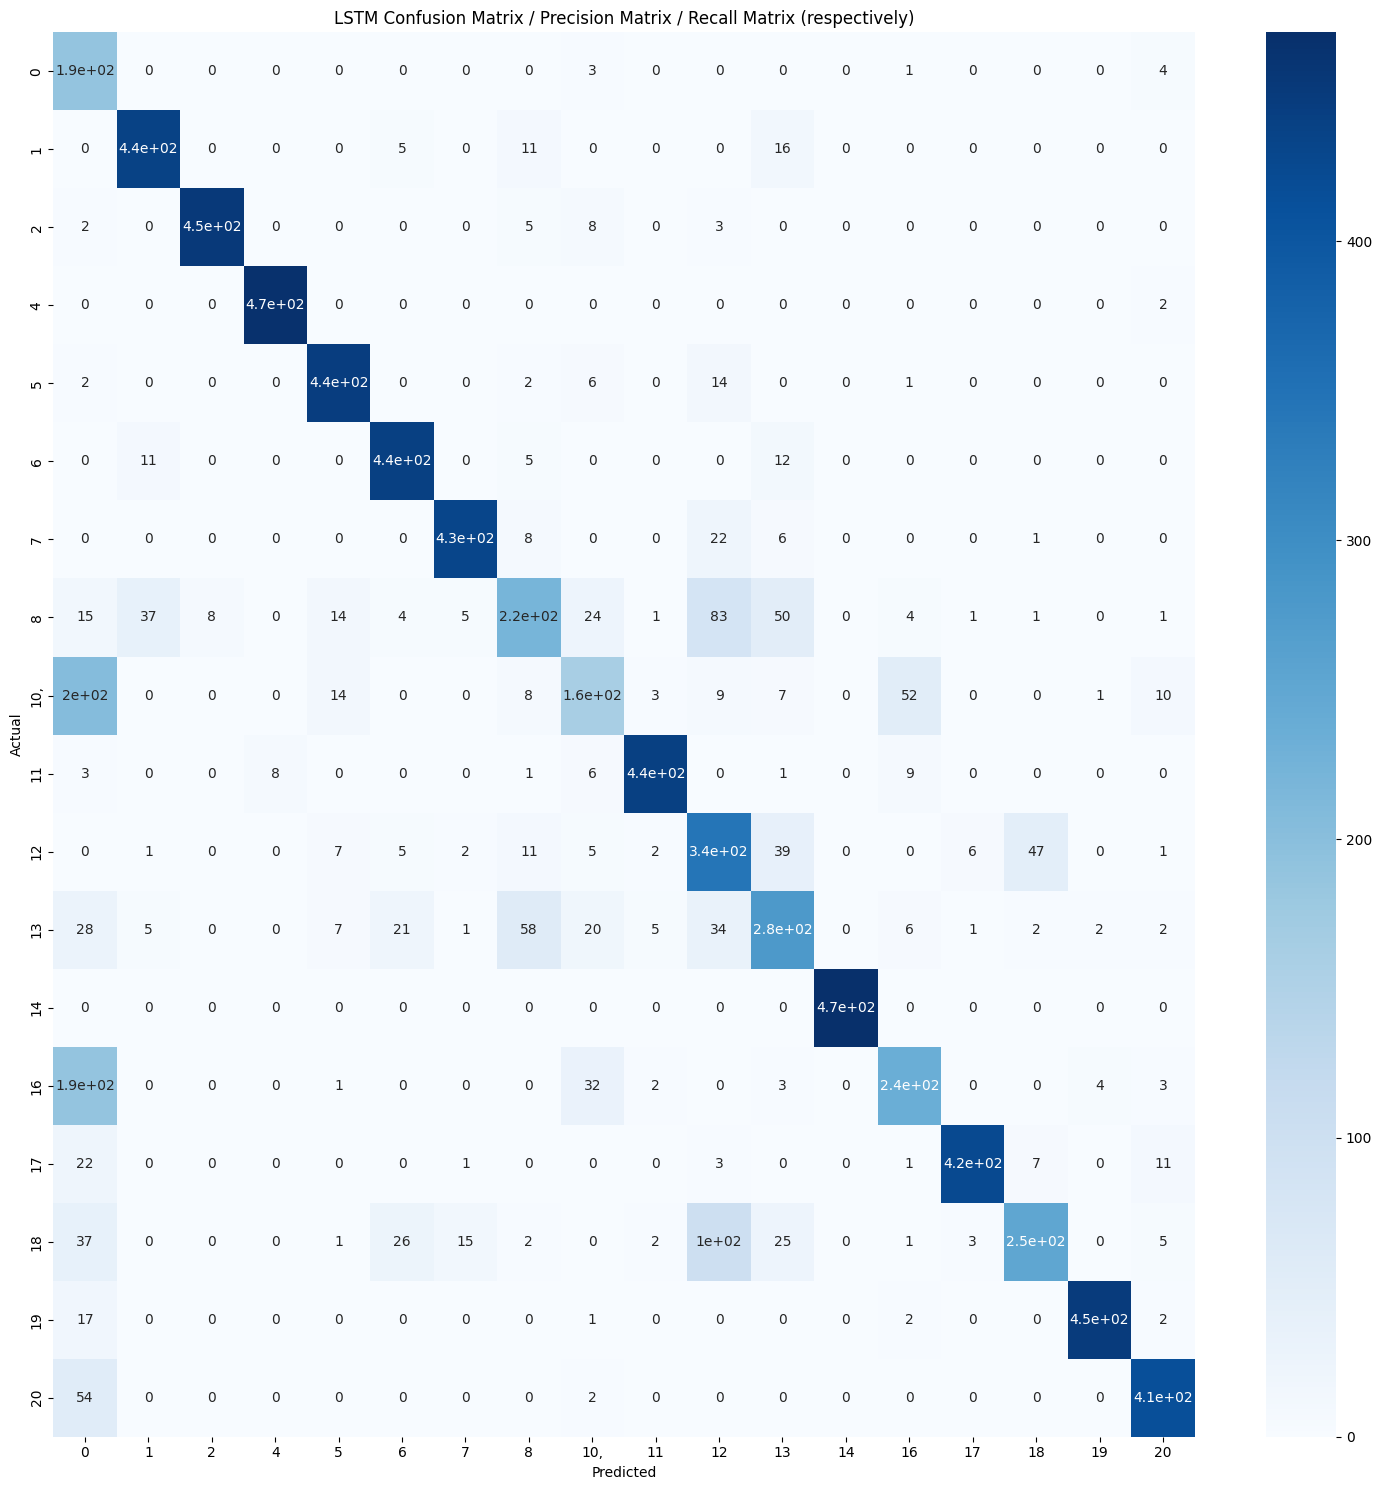

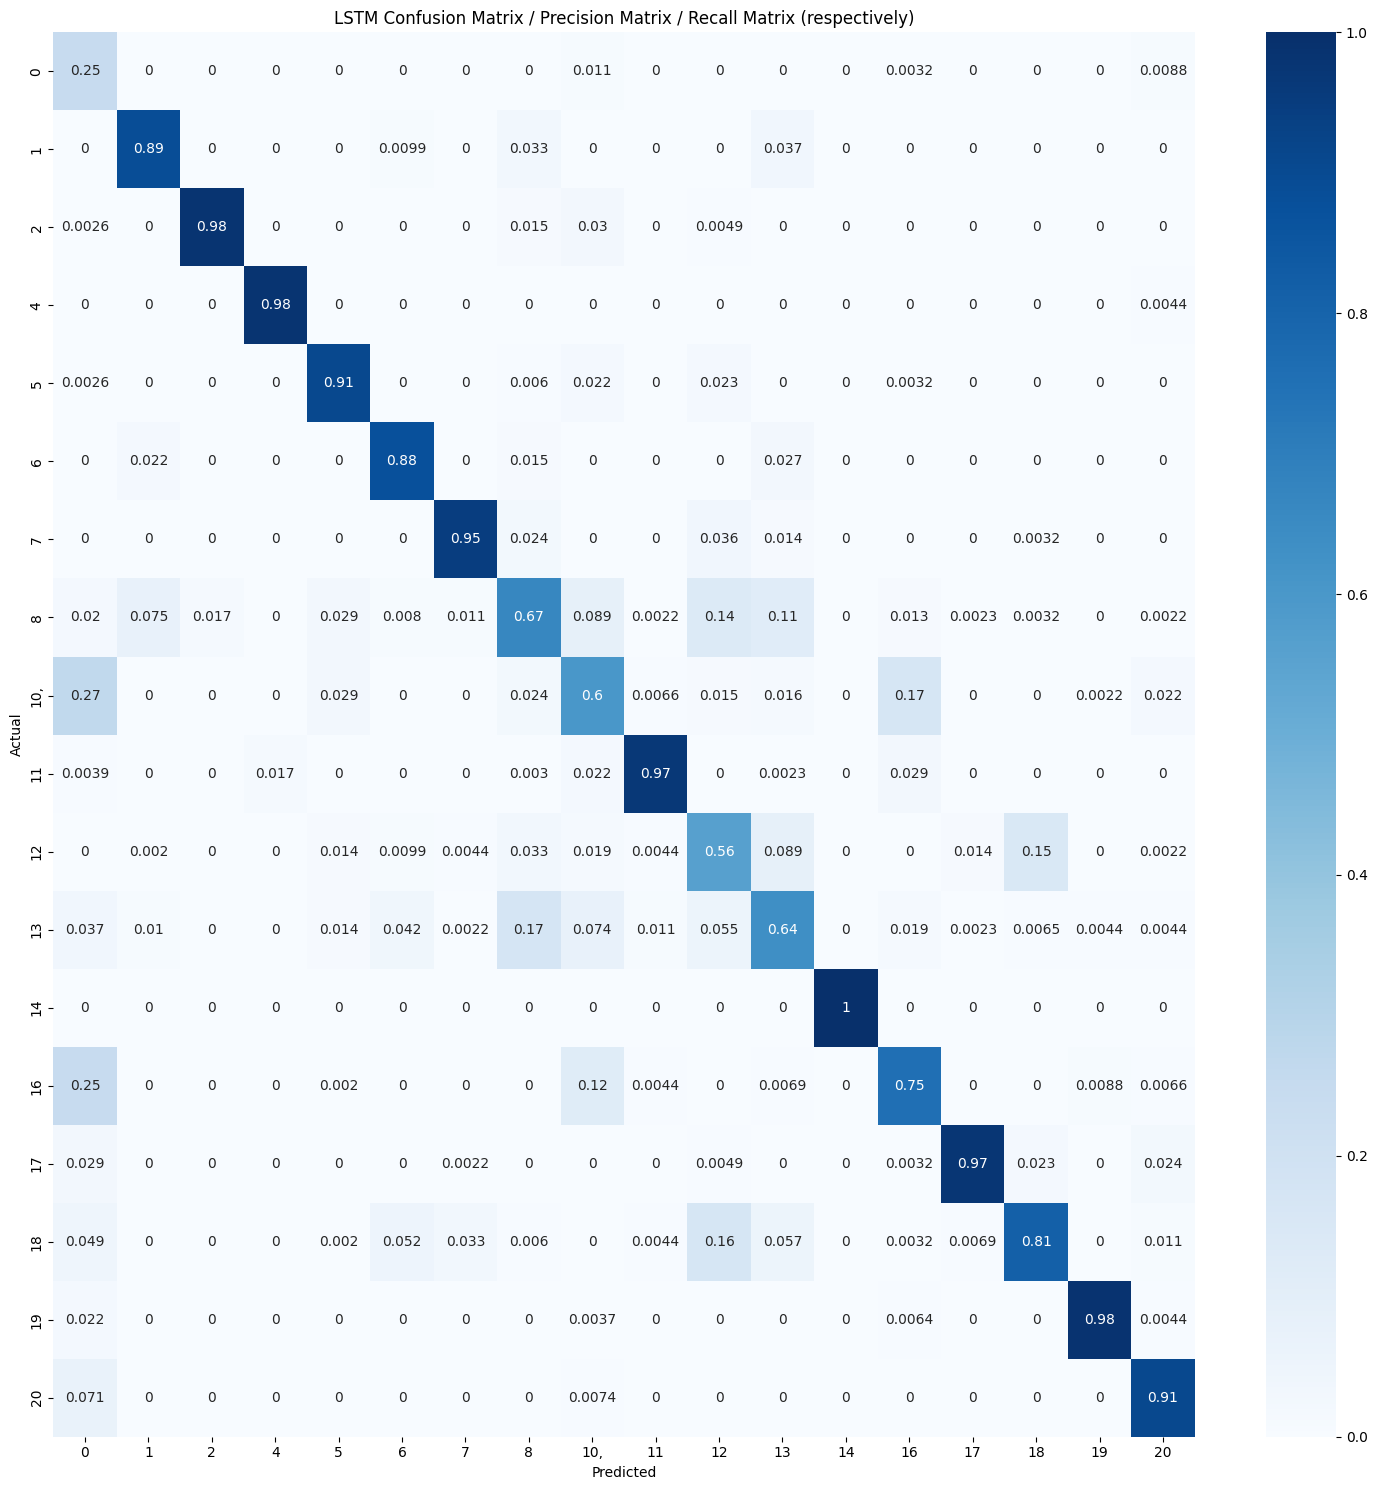

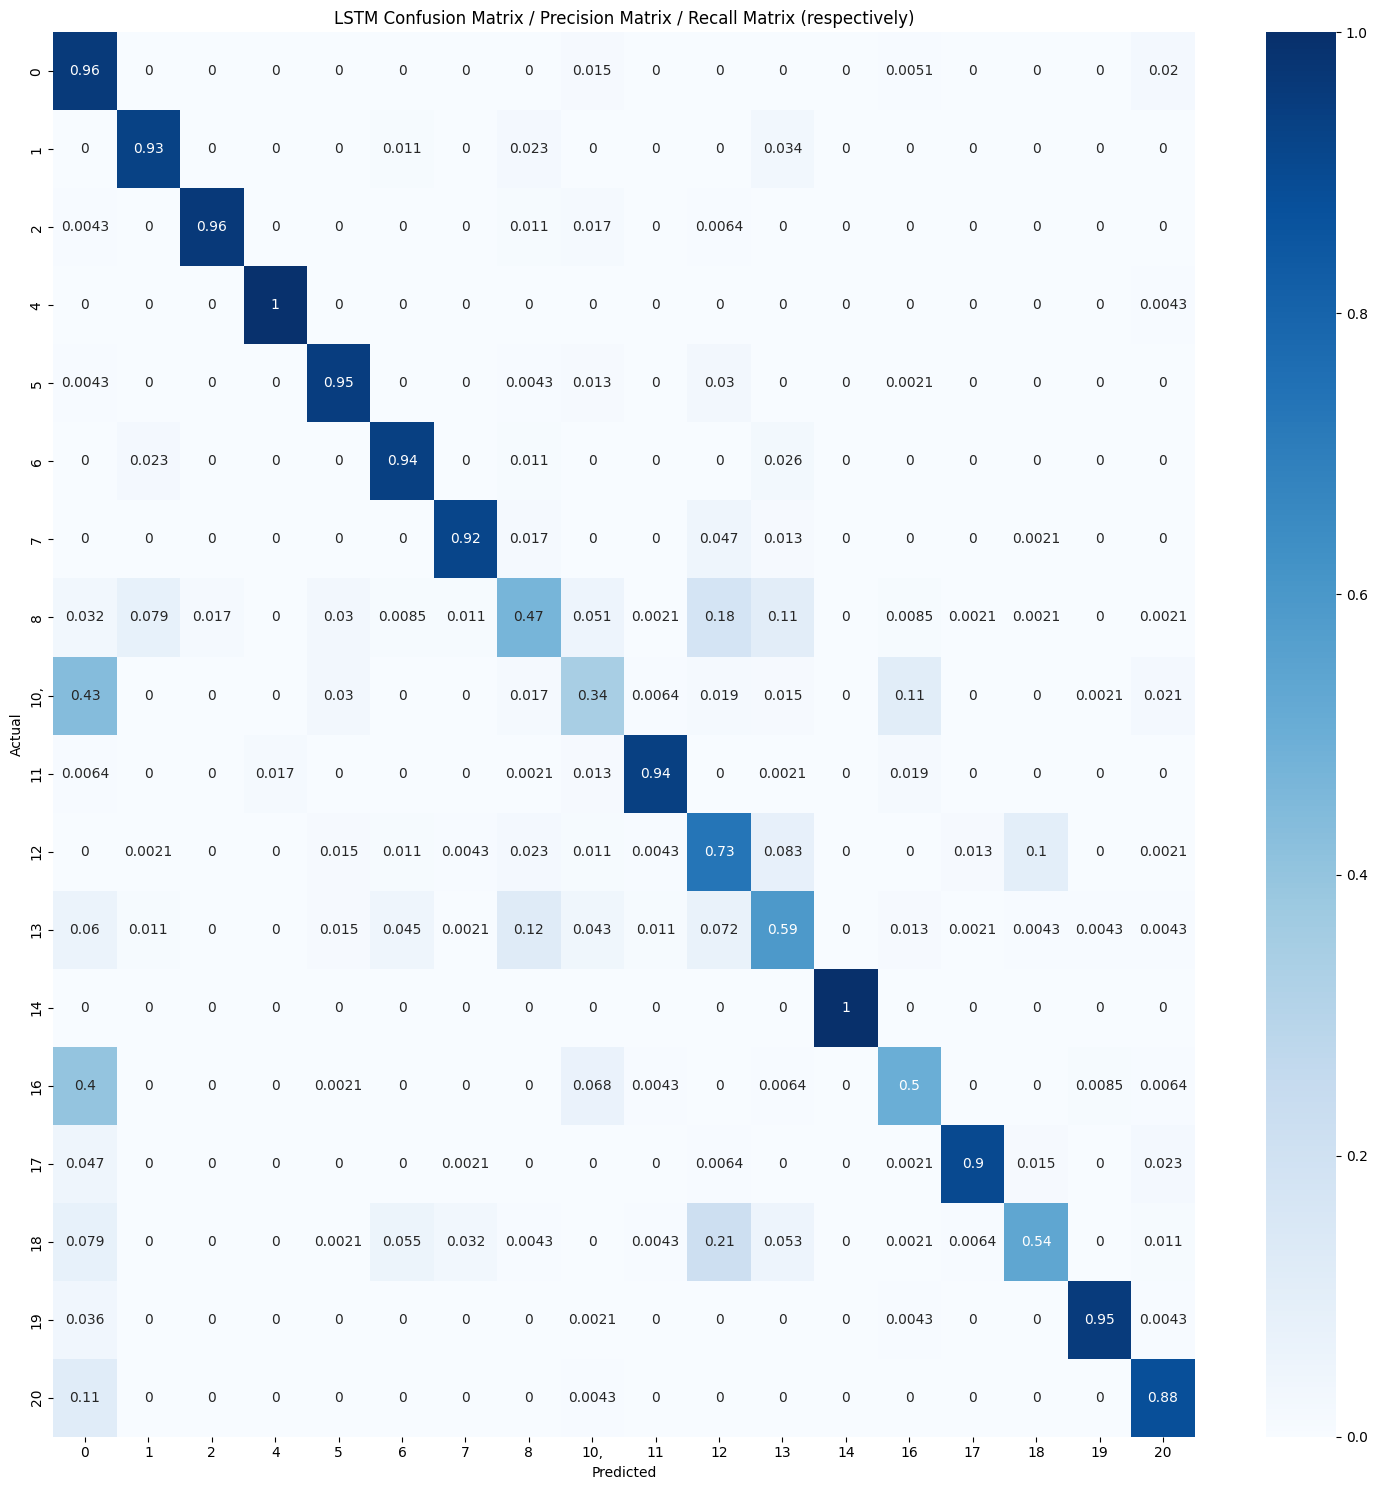

Aggregate Precision (including all classes): 0.817
Aggregate Precision (excluding class '0'): 0.851
LSTM Classification (More Faults) accuracy_score: 0.8012703065836082


In [ ]:
plot_confusion_matrix_1(y_true, y_pred, 'LSTM Confusion Matrix / Precision Matrix / Recall Matrix (respectively)')
print("LSTM Classification (More Faults) accuracy_score:", accuracy_score(y_true, y_pred))

In [ ]:



#######Biderectional LSTM Integrated with Neural Network CLassifier######




In [ ]:
def LSTM_model(X_train,y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))

    # Define encoder layers
    encoded = Bidirectional(LSTM(128,activation="tanh",return_sequences=True))(input_layer)
    encoded = LSTM(128, activation="tanh")(encoded)

    # Define decoder layers
    decoded = Dense(300, activation='selu')(encoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='softmax')(decoded)

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=decoded)
    # Compile LSTM  model
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return lstm_model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 33)]          0         
                                                                 
 bidirectional (Bidirection  (None, 20, 256)           165888    
 al)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_1 (Dense)             (None, 300)               38700     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 18)                5418      
                                                             

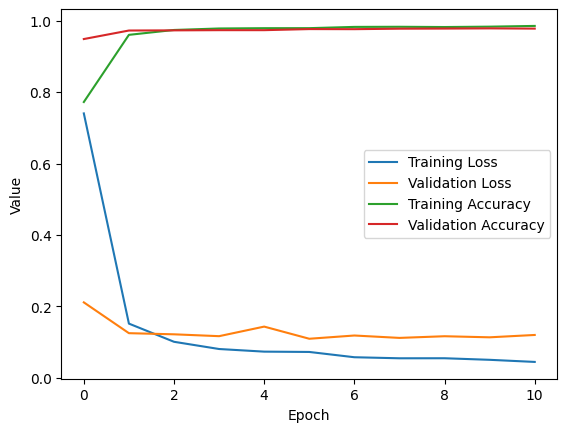

In [ ]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model = LSTM_model(X_train_sc,Y_train_enc)
model.summary()
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(X_train_sc, Y_train_enc, epochs=200, batch_size=256, validation_data=(X_cv_sc, Y_cv_enc), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define your custom class labels
custom_labels = ['0', '1', '2', '4', '5', '6', '7', '8', '10,','11', '12', '13', '14', '16', '17', '18', '19','20']

# Create a function to plot the confusion matrix with custom labels
def plot_confusion_matrix_1(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    precision = confusion_matrix(y_true, y_pred, normalize='pred')
    sns.heatmap(precision, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(precision), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    recall = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(recall, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(recall), 0)
    plt.tight_layout()
    plt.show()


    trace = np.diag(precision)

     # Sum of the trace (the sum of the diagonal elements of the confusion matrix) gives total true positives
    total_true_positives = np.sum(trace)

# Calculate the aggregate precision including class '0'
# Divide the total true positives by the number of classes
    aggregate_precision_including = total_true_positives / len(custom_labels)
    print(f"Aggregate Precision (including all classes): {aggregate_precision_including:.3f}")

# Calculate the aggregate precision excluding class '0'
# Subtract the true positives of class '0' from the total true positives and divide by the number of classes minus one
    aggregate_precision_excluding = (total_true_positives - trace[0]) / (len(custom_labels) - 1)
    print(f"Aggregate Precision (excluding class '0'): {aggregate_precision_excluding:.3f}")


In [ ]:
y_pred = enc_1.inverse_transform(model.predict(X_test_sc, verbose=0))

In [ ]:
y_true = enc_1.inverse_transform(Y_test_enc)

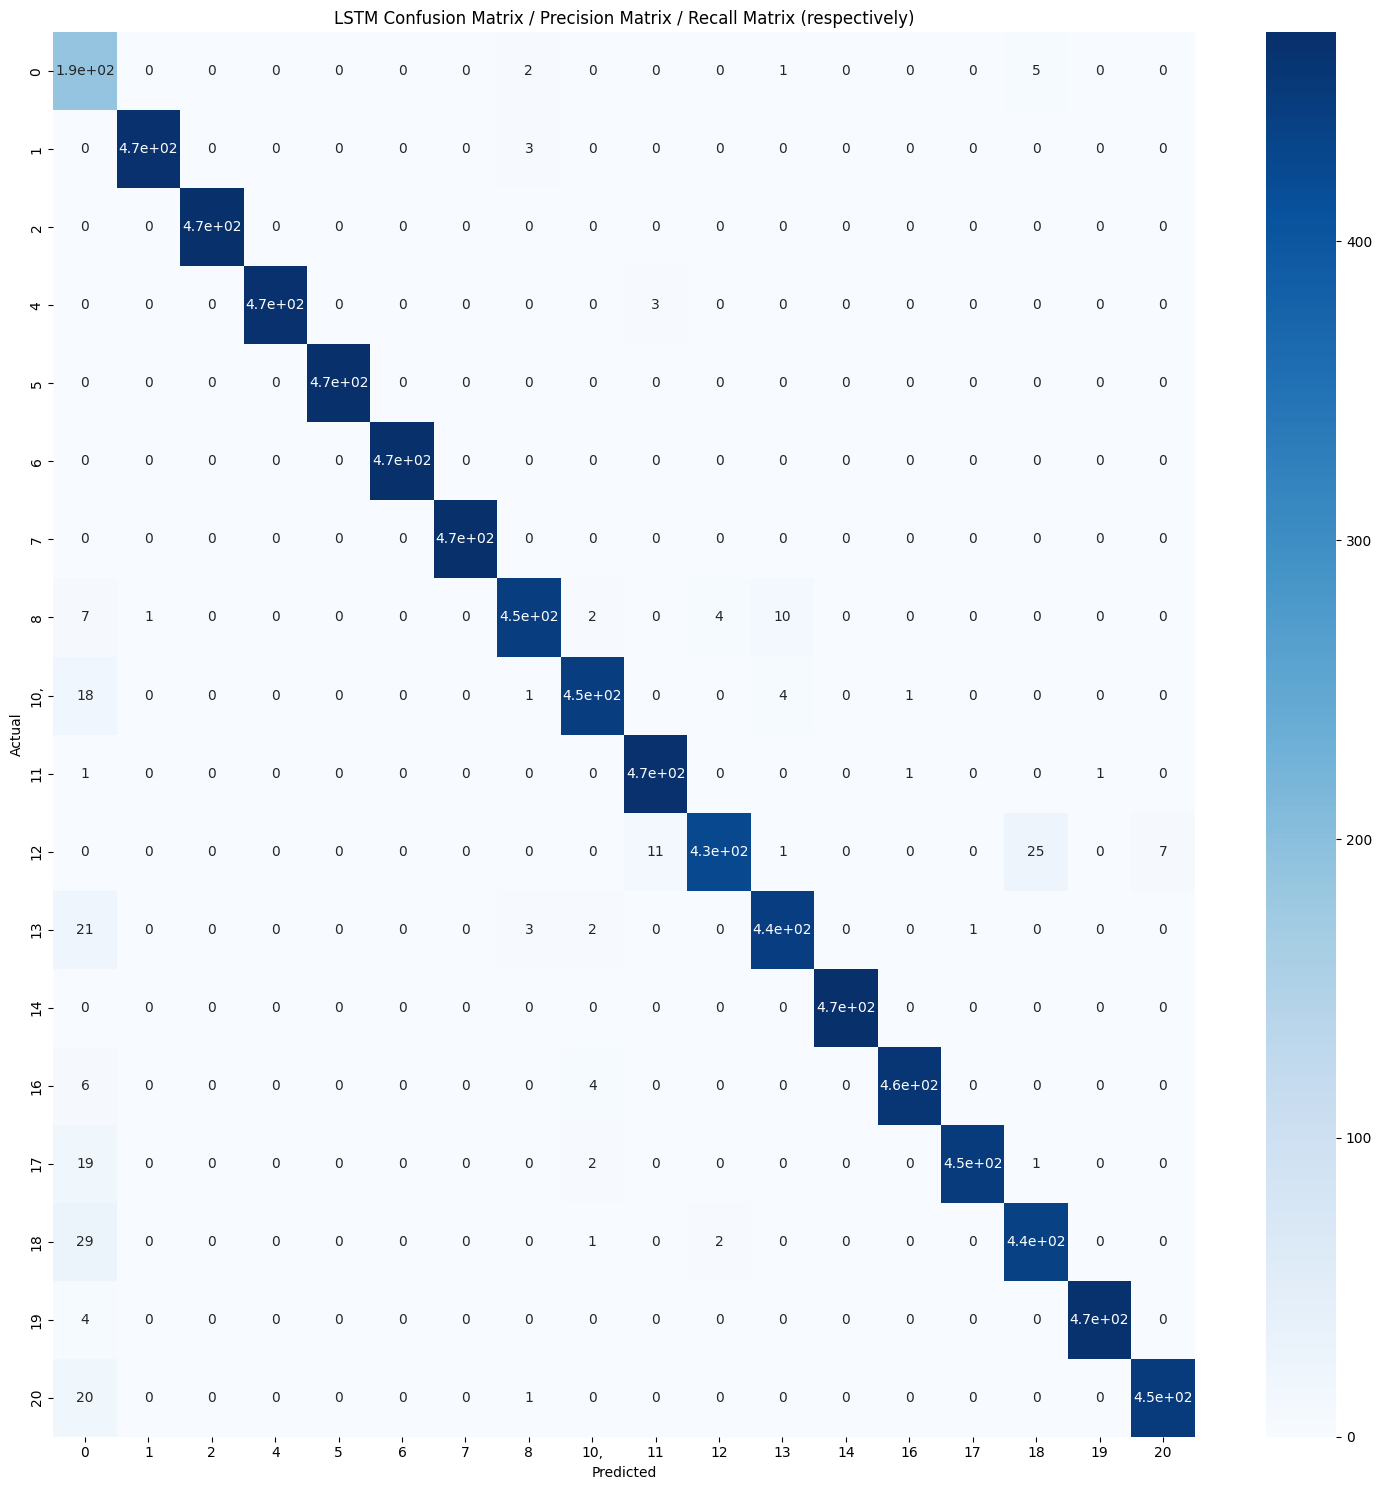

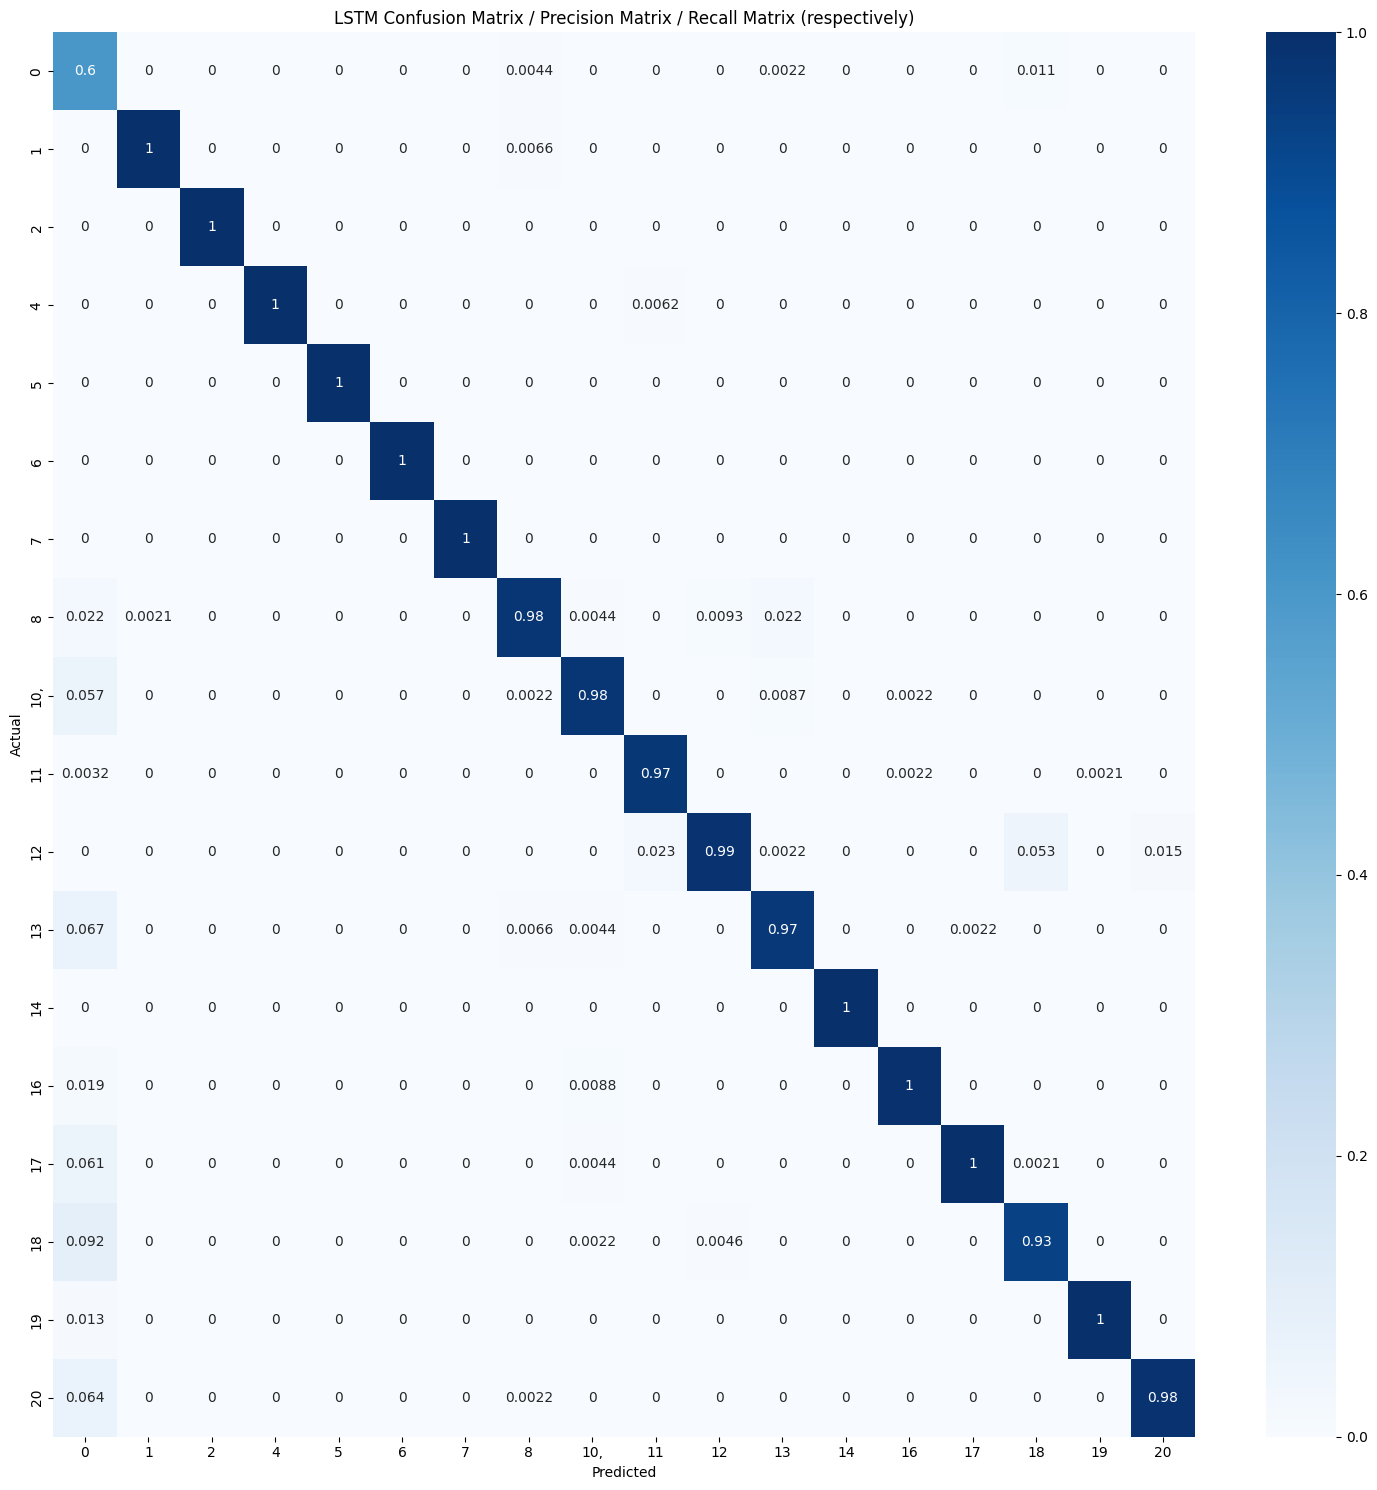

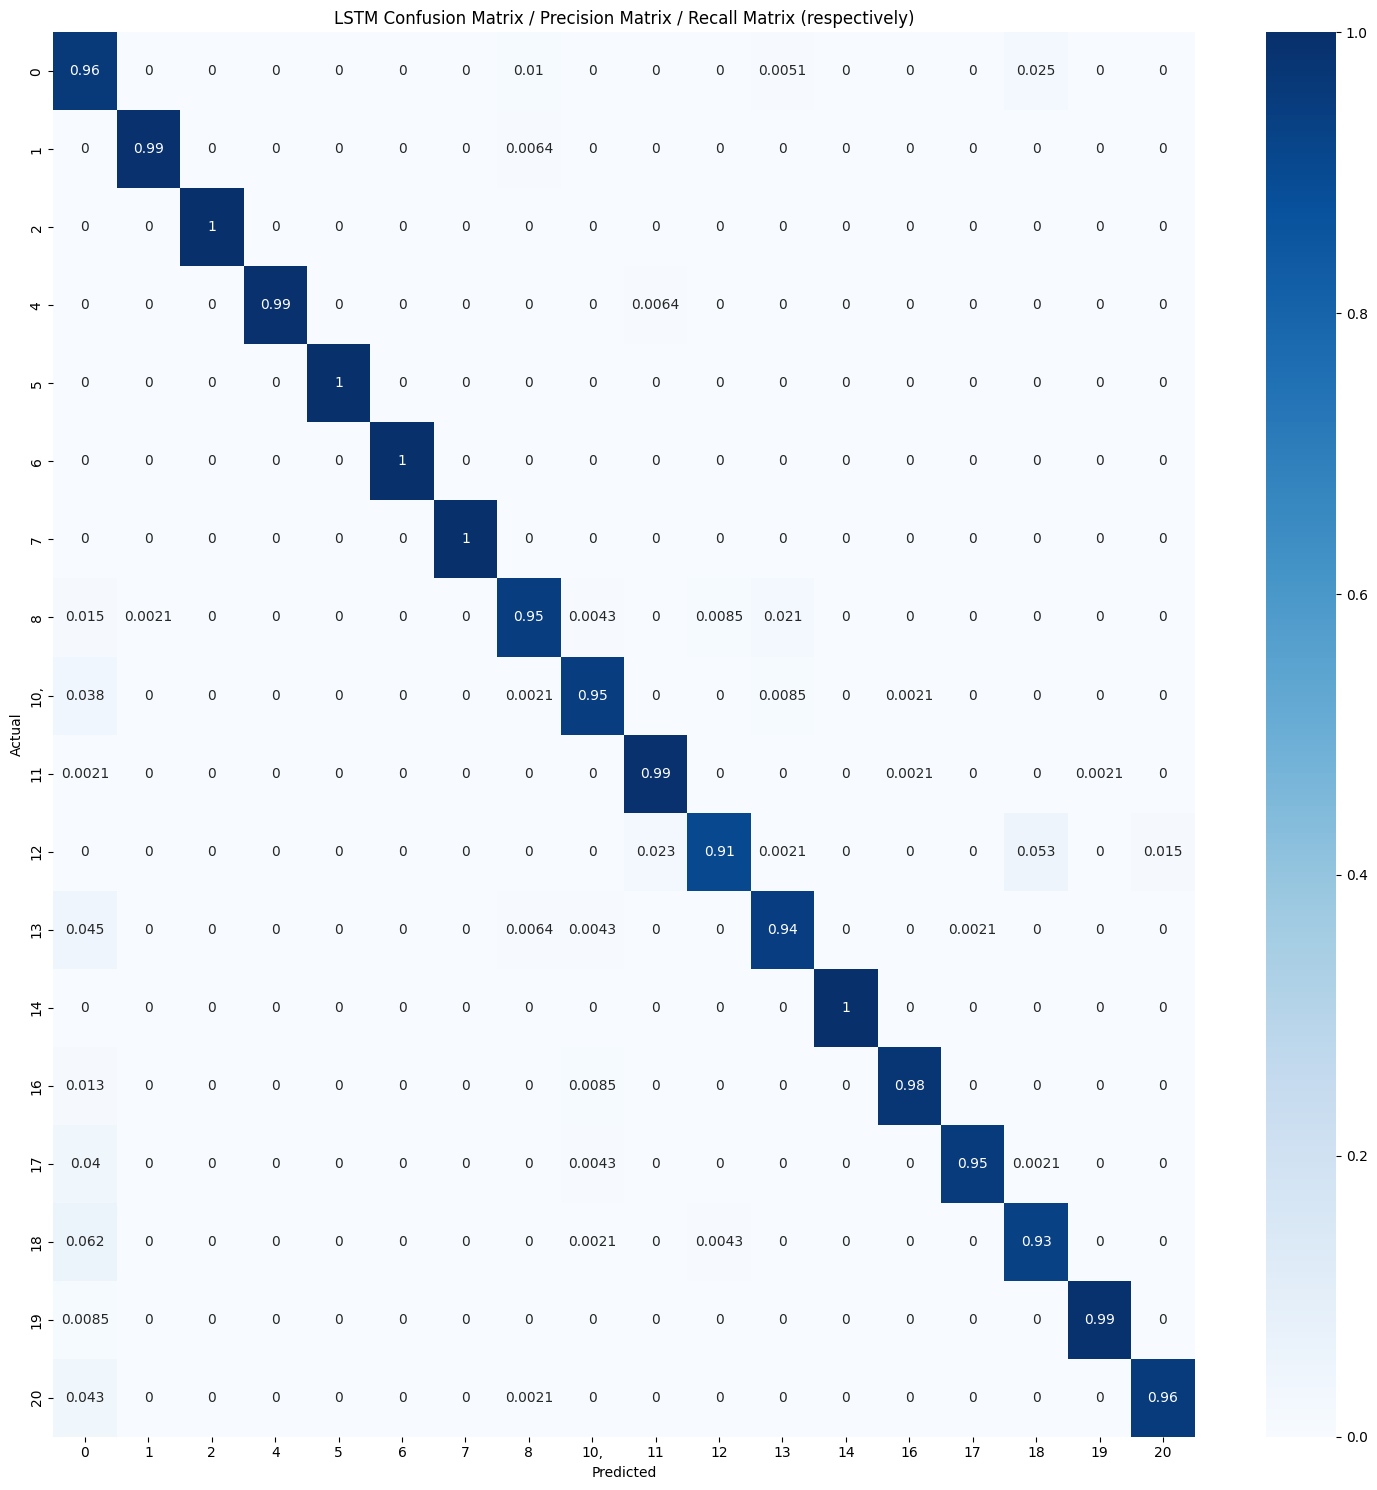

Aggregate Precision (including all classes): 0.966
Aggregate Precision (excluding class '0'): 0.987
Bidirectional LSTM integrated with ANN (More Faults) Classification accuracy_score: 0.9725174056430927


In [ ]:
plot_confusion_matrix_1(y_true, y_pred, 'LSTM Confusion Matrix / Precision Matrix / Recall Matrix (respectively)')
print("Bidirectional LSTM integrated with ANN (More Faults) Classification accuracy_score:", accuracy_score(y_true, y_pred))

In [ ]:





#######Dataset with less faults#########





In [ ]:
# Removing faults 3, 5, 8, 9, 10, 12, 15, 16, and 18.
tr_1 = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15) | (train.faultNumber == 5) | (train.faultNumber == 8) | (train.faultNumber == 10) | (train.faultNumber == 12) | (train.faultNumber == 16) | (train.faultNumber == 18)].index).reset_index()
ts_1 = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15) | (test.faultNumber == 5) | (test.faultNumber == 8) | (test.faultNumber == 10) | (test.faultNumber == 12) | (test.faultNumber == 16) | (test.faultNumber == 18)].index).reset_index()
cv_1 = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15) | (cv.faultNumber == 5) | (cv.faultNumber == 8) | (cv.faultNumber == 10) | (cv.faultNumber == 12) | (cv.faultNumber == 16) | (cv.faultNumber == 18)].index).reset_index()

In [ ]:
# Map fault numbers to a new continuous range
mapping = {0:0, 1:1, 2:2, 4:3, 6:4, 7:5, 11:6, 13:7, 14:8, 17:9, 19:10, 20:11}
tr_1['mappedFaultNumber'] = tr_1['faultNumber'].map(mapping)
ts_1['mappedFaultNumber'] = ts_1['faultNumber'].map(mapping)
cv_1['mappedFaultNumber'] = cv_1['faultNumber'].map(mapping)

In [ ]:
print(tr_1.shape)

(152000, 58)


In [ ]:
print(tr_1.head())

   index  Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0      0           0          0.0            1.0       1  0.25038   3674.0   
1      1           1          0.0            1.0       2  0.25109   3659.4   
2      2           2          0.0            1.0       3  0.25038   3660.3   
3      3           3          0.0            1.0       4  0.24977   3661.3   
4      4           4          0.0            1.0       5  0.29405   3679.0   

   xmeas_3  xmeas_4  xmeas_5  ...   xmv_3   xmv_4   xmv_5   xmv_6   xmv_7  \
0   4529.0   9.2320   26.889  ...  24.657  62.544  22.137  39.935  42.323   
1   4556.6   9.4264   26.721  ...  24.588  59.259  22.084  40.176  38.554   
2   4477.8   9.4426   26.875  ...  24.666  61.275  22.380  40.244  38.990   
3   4512.1   9.4776   26.758  ...  24.725  59.856  22.277  40.257  38.072   
4   4497.0   9.3381   26.889  ...  28.797  60.717  21.947  39.144  41.955   

    xmv_8   xmv_9  xmv_10  xmv_11  mappedFaultNumber  
0  47.757  47

In [ ]:
 # Column names to drop
columns_to_drop = tr_1.columns[27:46]

# Drop the columns from the dataframes
tr_1.drop(columns_to_drop, axis=1, inplace=True)
ts_1.drop(columns_to_drop, axis=1, inplace=True)
cv_1.drop(columns_to_drop, axis=1, inplace=True)


In [ ]:
tr_1.shape

(152000, 39)

In [ ]:

def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_train = []
Y_train = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 12):  # Iterating correctly from 0 to 11
    max_runs = 40 if j == 0 else 25  # Assuming faultNumber 0 is fault-free
    for i in range(1, max_runs + 1):  # Iterate over the correct number of simulation runs
        df = tr_1[(tr_1['mappedFaultNumber'] == j) & (tr_1['simulationRun'] == i)]
        x_temp, y_temp = SlidingWindow(df, w, s)
        X_train.extend(x_temp)
        Y_train.extend(y_temp)

# Convert X and Y to numpy arrays and reshape X for LSTM
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train = X_train.reshape(-1, w, X_train.shape[-1])

X_train.shape, Y_train.shape


((14885, 20, 33), (14885,))

In [ ]:
print(Y_train.shape)

(14885,)


In [ ]:
print(tr_1.head())

   index  Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0      0           0          0.0            1.0       1  0.25038   3674.0   
1      1           1          0.0            1.0       2  0.25109   3659.4   
2      2           2          0.0            1.0       3  0.25038   3660.3   
3      3           3          0.0            1.0       4  0.24977   3661.3   
4      4           4          0.0            1.0       5  0.29405   3679.0   

   xmeas_3  xmeas_4  xmeas_5  ...   xmv_3   xmv_4   xmv_5   xmv_6   xmv_7  \
0   4529.0   9.2320   26.889  ...  24.657  62.544  22.137  39.935  42.323   
1   4556.6   9.4264   26.721  ...  24.588  59.259  22.084  40.176  38.554   
2   4477.8   9.4426   26.875  ...  24.666  61.275  22.380  40.244  38.990   
3   4512.1   9.4776   26.758  ...  24.725  59.856  22.277  40.257  38.072   
4   4497.0   9.3381   26.889  ...  28.797  60.717  21.947  39.144  41.955   

    xmv_8   xmv_9  xmv_10  xmv_11  mappedFaultNumber  
0  47.757  47

In [ ]:
# Initialize a StandardScaler object
sc = StandardScaler()

# Filter the DataFrame to only include data from the first simulation run
reduced_data = tr_1[tr_1['faultNumber']==0]
# Select the rows from the reduced dataset that have faultNumber equal to 0, and extract the feature values
fault_free = reduced_data[(reduced_data['faultNumber'] == 0)].iloc[:, 5:-1]

# Fit the StandardScaler object to the feature values of the fault-free data
sc.fit(fault_free)

StandardScaler()

In [ ]:
X_train_sc = sc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

In [ ]:
print(X_train_sc.shape)

(14885, 20, 33)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, Dense, LSTM,Conv2D,Conv1D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Dropout,Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Input

In [ ]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc.fit(Y_train.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_train_enc = enc.transform(Y_train.reshape(-1, 1))

In [ ]:
print(Y_train_enc.shape)

(14885, 12)


In [ ]:
## Now Prepare CV and Test Data Set

In [ ]:

def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_test = []
Y_test = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 12):  # Iterating correctly from 0 to 11
    max_runs = 3 if j == 0 else 10  # Assuming faultNumber 0 is fault-free
    for i in range(1, max_runs + 1):  # Iterate over the correct number of simulation runs
        df = ts_1[(ts_1['mappedFaultNumber'] == j) & (ts_1['simulationRun'] == i)]
        x_temp, y_temp = SlidingWindow(df, w, s)
        X_test.extend(x_temp)
        Y_test.extend(y_temp)

# Convert X and Y to numpy arrays and reshape X for LSTM
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = X_test.reshape(-1, w, X_test.shape[-1])

X_test.shape, Y_test.shape


((5367, 20, 33), (5367,))

In [ ]:


def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_cv = []
Y_cv = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 12):  # Iterating correctly from 0 to 11
    if j == 0:
        max_runs = 20  # Assuming faultNumber 0 is fault-free
        for i in range(41, max_runs + 41):  # Iterate over the correct number of simulation runs
            df = cv_1[(cv_1['mappedFaultNumber'] == j) & (cv_1['simulationRun'] == i)]
            x_temp, y_temp = SlidingWindow(df, w, s)
            X_cv.extend(x_temp)
            Y_cv.extend(y_temp)
    else:
        max_runs = 10
        for i in range(26, max_runs + 26):  # Iterate over the range 26 to max_runs
            df = cv_1[(cv_1['mappedFaultNumber'] == j) & (cv_1['simulationRun'] == i)]
            x_temp, y_temp = SlidingWindow(df, w, s)
            X_cv.extend(x_temp)
            Y_cv.extend(y_temp)


# Convert X and Y to numpy arrays and reshape X for LSTM
X_cv = np.array(X_cv)
Y_cv = np.array(Y_cv)
X_cv = X_cv.reshape(-1, w, X_cv.shape[-1])

X_cv.shape, Y_cv.shape


((6150, 20, 33), (6150,))

In [ ]:
print(X_cv[0,:,-1])

[19.807 17.919 19.579 16.9   19.291 16.629 17.457 18.343 18.65  17.924
 20.155 18.812 15.903 17.382 17.416 15.328 19.123 19.999 19.95  17.681]


In [ ]:
X_test_sc = sc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
X_cv_sc = sc.transform(X_cv.reshape(-1, X_cv.shape[-1])).reshape(X_cv.shape)

In [ ]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc_1 = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc_1.fit(Y_test.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_test_enc = enc_1.transform(Y_test.reshape(-1, 1))

In [ ]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc_2 = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc_2.fit(Y_cv.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_cv_enc = enc_2.transform(Y_cv.reshape(-1, 1))

In [ ]:
Y_test.shape

(5367,)

In [ ]:



#######Basic LSTM Model#######




In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def build_lstm_model(X_train, y_train, num_classes):
    # Create a Sequential model
    model = Sequential()

    # Add an LSTM layer
    model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

    # Add a dropout layer for regularization
    model.add(Dropout(0.2))

    # Add another LSTM layer
    model.add(LSTM(32, activation='relu'))

    # Add a dense layer for classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 64)            25088     
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 12)                396       
                                                                 
Total params: 37900 (148.05 KB)
Trainable params: 37900 (148.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
59/59 [==============================] - 14s 167ms/step - loss: 4.9194 - accuracy: 0.1935 - val_loss: 2.0401 - val_accuracy: 0.4127
Epoc

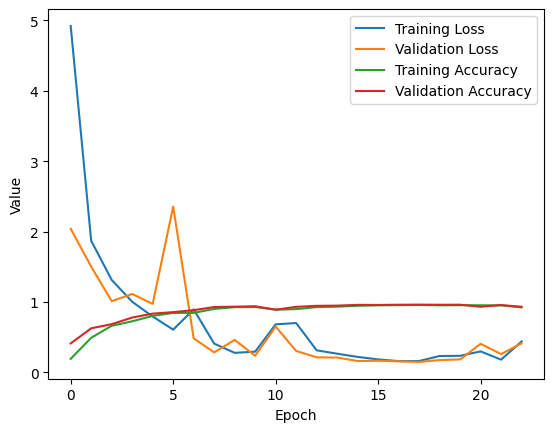

In [ ]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model_temp_1 = build_lstm_model(X_train_sc,Y_train_enc, 12)
model_temp_1.summary()
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model_temp_1.fit(X_train_sc, Y_train_enc, epochs=200, batch_size=256, validation_data=(X_cv_sc, Y_cv_enc), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define custom class labels
custom_labels = ['0', '1', '2', '4', '6', '7', '11', '13', '14', '17', '19', '20']

# Create a function to plot the confusion matrix with custom labels
def plot_confusion_matrix_1(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    precision = confusion_matrix(y_true, y_pred, normalize='pred')
    sns.heatmap(precision, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(precision), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    recall = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(recall, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(recall), 0)
    plt.tight_layout()
    plt.show()


    trace = np.diag(precision)

     # Sum of the trace (the sum of the diagonal elements of the confusion matrix) gives total true positives
    total_true_positives = np.sum(trace)

# Calculate the aggregate precision including class '0'
# Divide the total true positives by the number of classes
    aggregate_precision_including = total_true_positives / len(custom_labels)
    print(f"Aggregate Precision (including all classes): {aggregate_precision_including:.3f}")

# Calculate the aggregate precision excluding class '0'
# Subtract the true positives of class '0' from the total true positives and divide by the number of classes minus one
    aggregate_precision_excluding = (total_true_positives - trace[0]) / (len(custom_labels) - 1)
    print(f"Aggregate Precision (excluding class '0'): {aggregate_precision_excluding:.3f}")


In [ ]:
y_pred = enc_1.inverse_transform(model_temp_1.predict(X_test_sc, verbose=0))

In [ ]:
y_true = enc_1.inverse_transform(Y_test_enc)

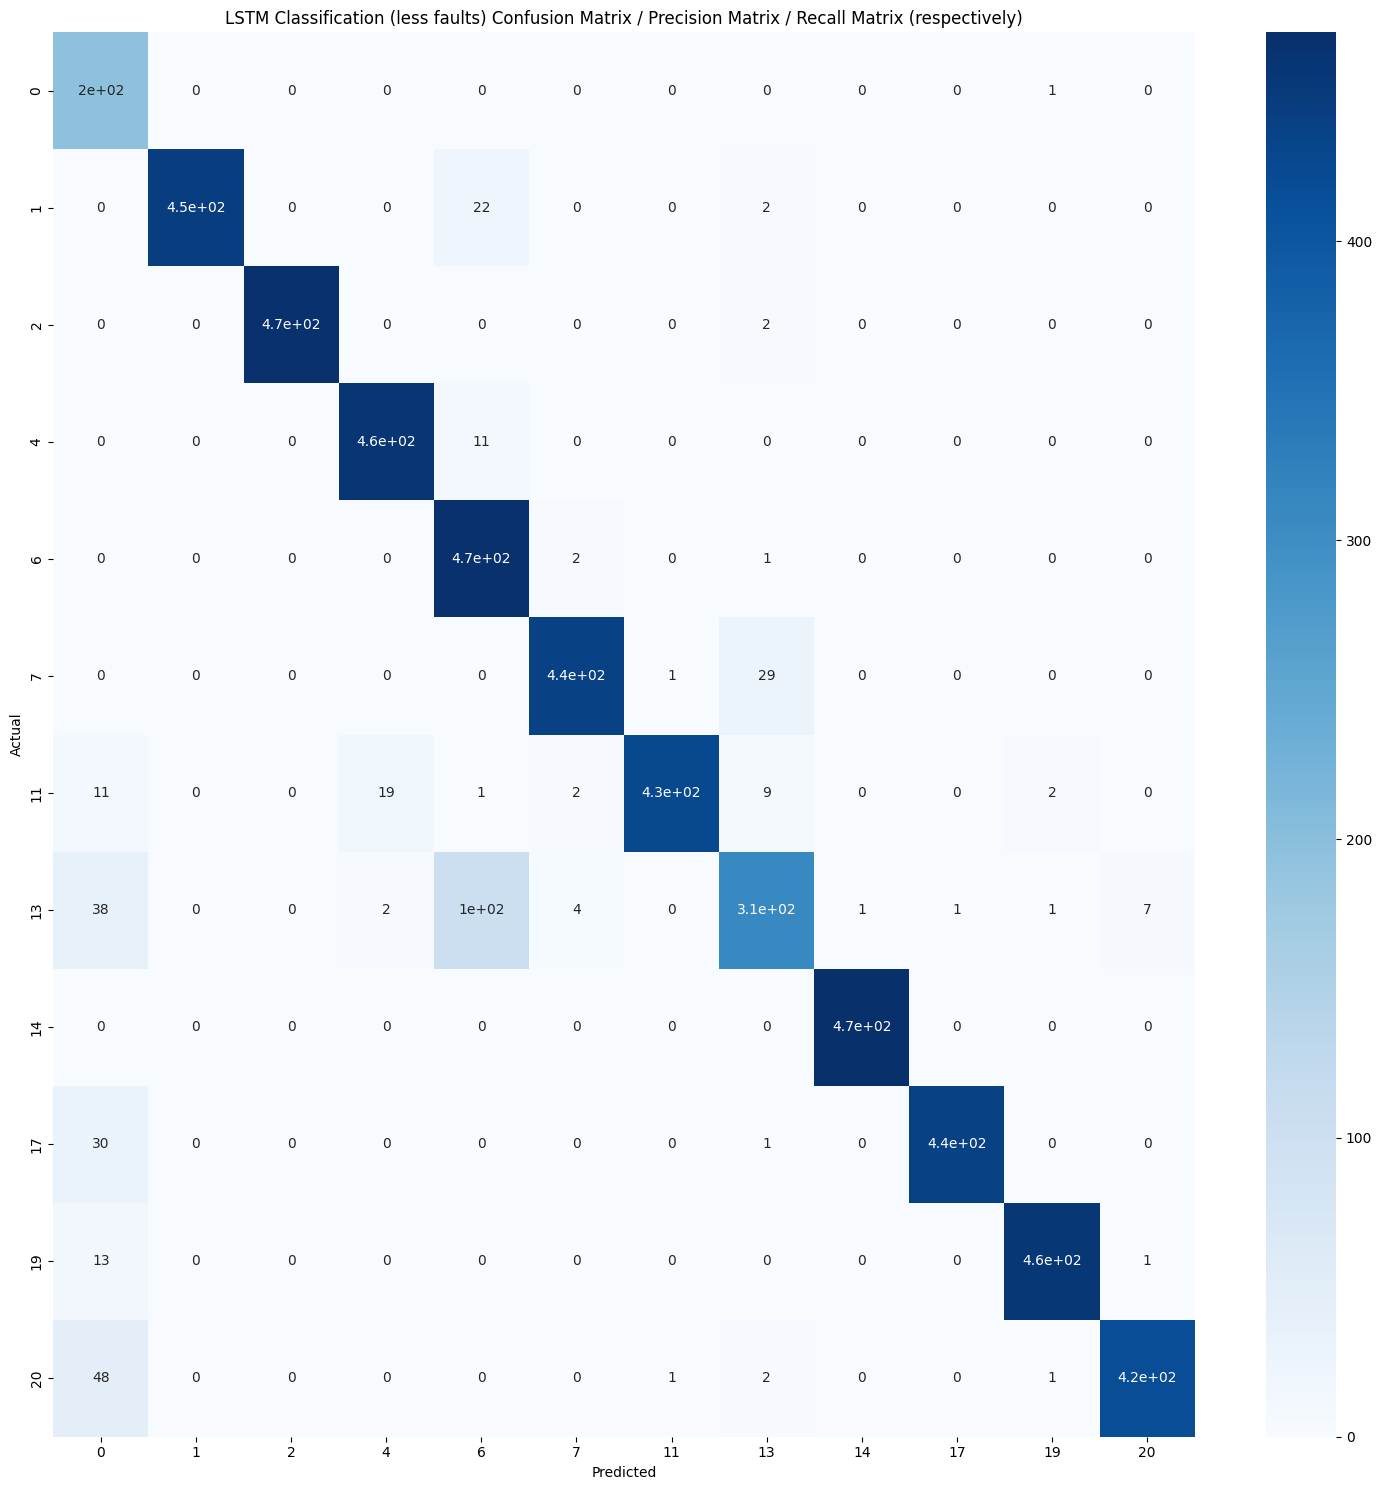

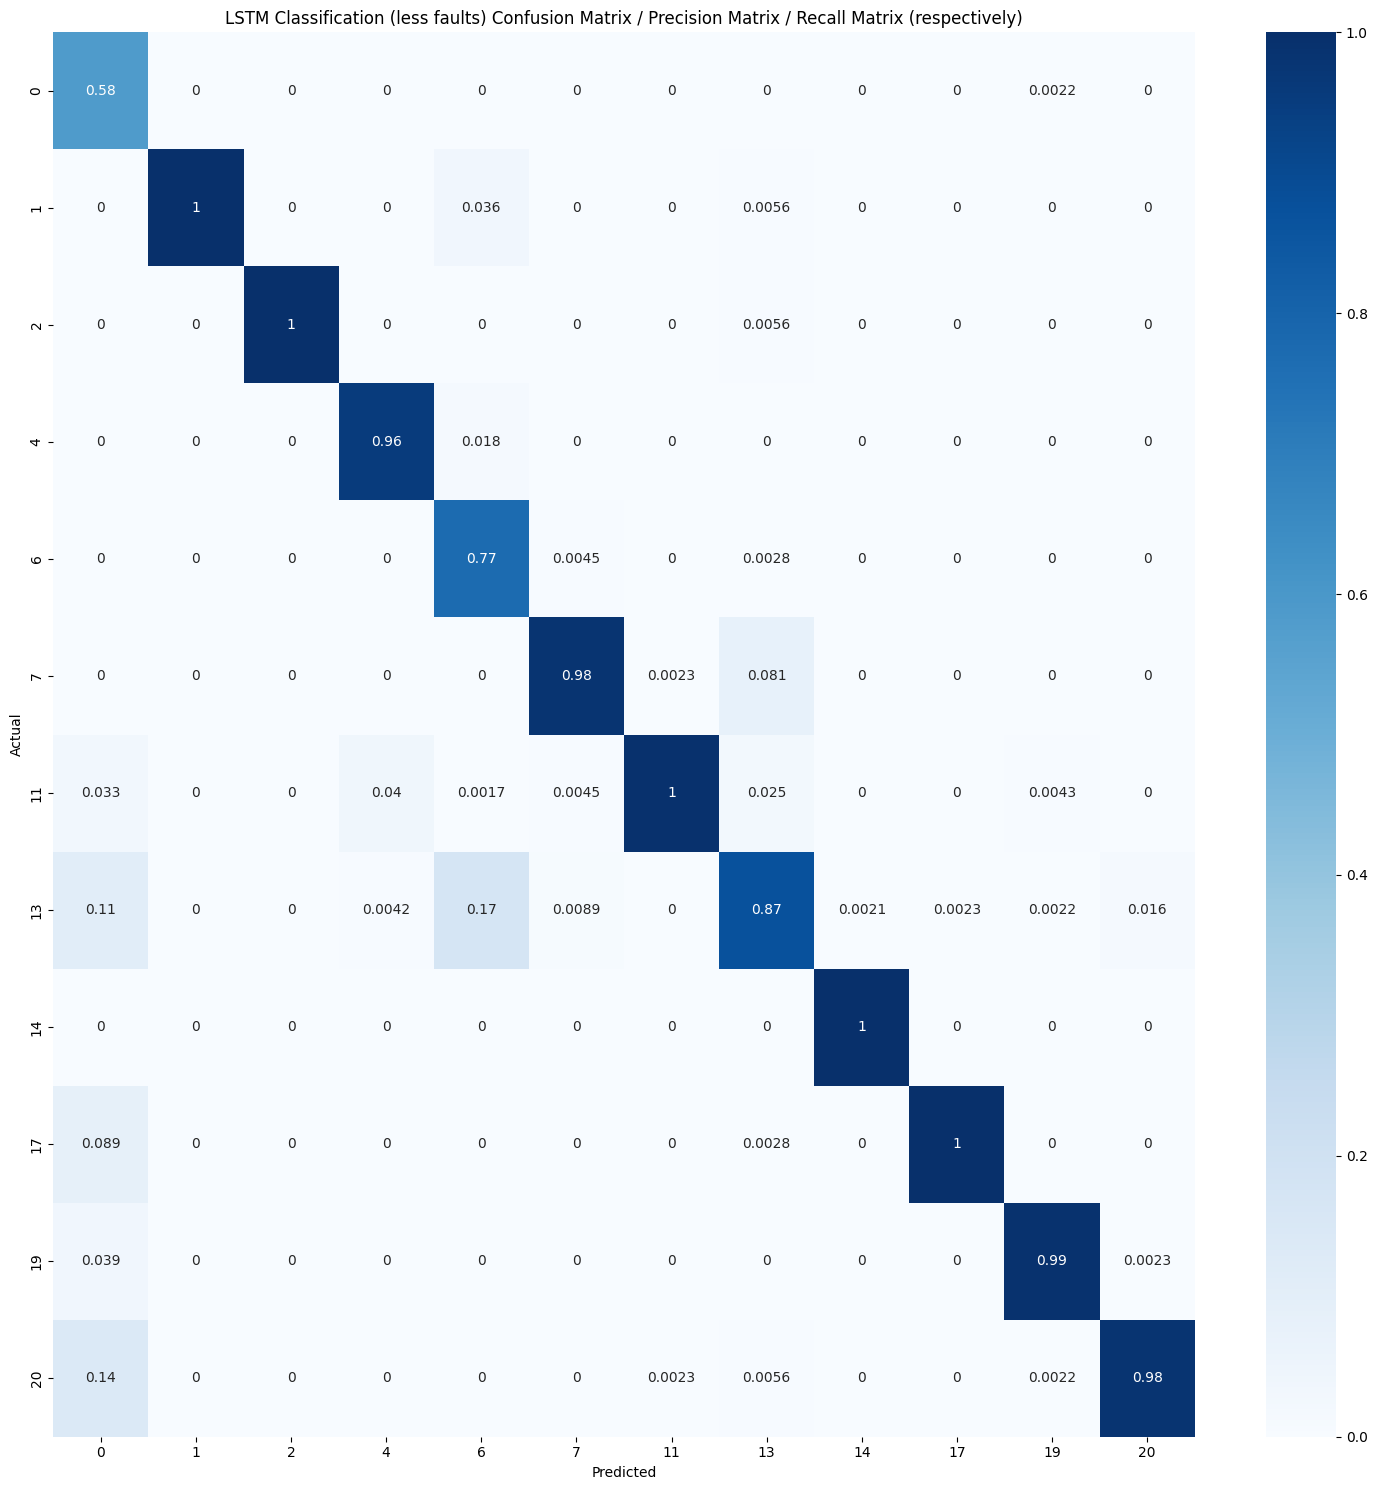

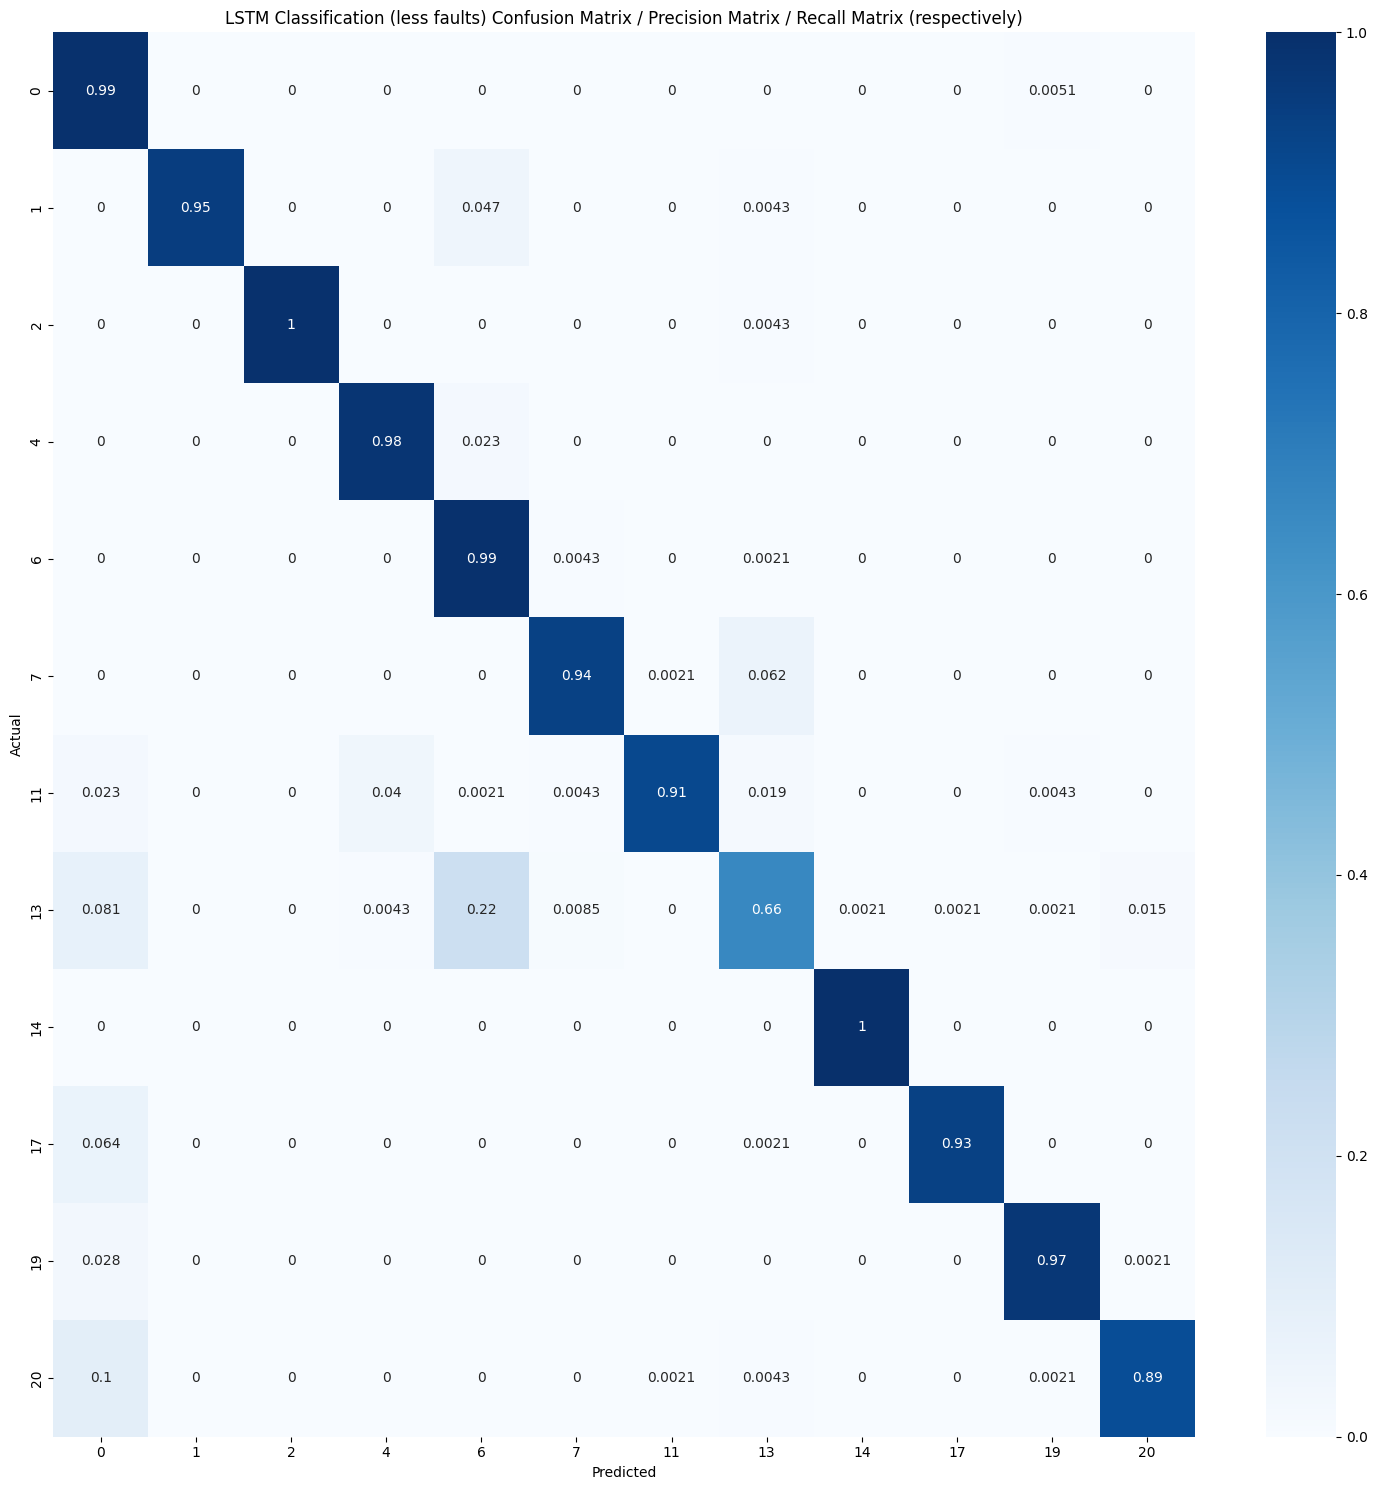

Aggregate Precision (including all classes): 0.927
Aggregate Precision (excluding class '0'): 0.958
LSTM Classification (less faults) accuracy_score: 0.9310601825973542


In [ ]:
plot_confusion_matrix_1(y_true, y_pred, 'LSTM Classification (less faults) Confusion Matrix / Precision Matrix / Recall Matrix (respectively)')
print("LSTM Classification (less faults) accuracy_score:", accuracy_score(y_true, y_pred))

In [ ]:



#######Biderectional LSTM Integrated with Neural Network CLassifier######




In [ ]:
def LSTM_model(X_train,y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))

    # Define encoder layers
    encoded = Bidirectional(LSTM(128,activation="tanh",return_sequences=True))(input_layer)
    encoded = LSTM(128, activation="tanh")(encoded)

    # Define decoder layers
    decoded = Dense(300, activation='selu')(encoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='softmax')(decoded)

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=decoded)
    # Compile LSTM  model
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return lstm_model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 33)]          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 20, 256)           165888    
 onal)                                                           
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 300)               38700     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                3612      
                                                           

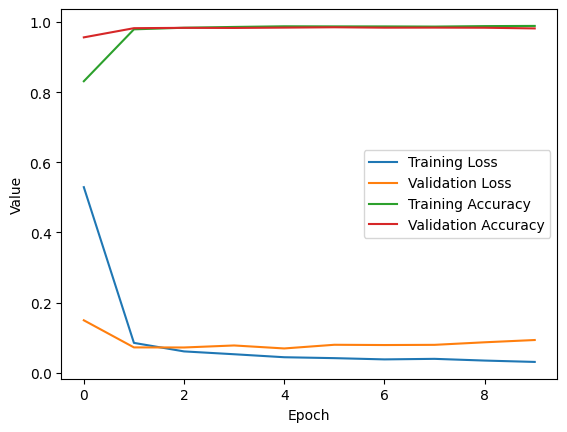

In [ ]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model = LSTM_model(X_train_sc,Y_train_enc)
model.summary()
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(X_train_sc, Y_train_enc, epochs=200, batch_size=256, validation_data=(X_cv_sc, Y_cv_enc), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define custom class labels
custom_labels = ['0', '1', '2', '4', '6', '7', '11', '13', '14', '17', '19', '20']

# Create a function to plot the confusion matrix with custom labels
def plot_confusion_matrix_1(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    precision = confusion_matrix(y_true, y_pred, normalize='pred')
    sns.heatmap(precision, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(precision), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    recall = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(recall, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(recall), 0)
    plt.tight_layout()
    plt.show()


    trace = np.diag(precision)

     # Sum of the trace (the sum of the diagonal elements of the confusion matrix) gives total true positives
    total_true_positives = np.sum(trace)

# Calculate the aggregate precision including class '0'
# Divide the total true positives by the number of classes
    aggregate_precision_including = total_true_positives / len(custom_labels)
    print(f"Aggregate Precision (including all classes): {aggregate_precision_including:.3f}")

# Calculate the aggregate precision excluding class '0'
# Subtract the true positives of class '0' from the total true positives and divide by the number of classes minus one
    aggregate_precision_excluding = (total_true_positives - trace[0]) / (len(custom_labels) - 1)
    print(f"Aggregate Precision (excluding class '0'): {aggregate_precision_excluding:.3f}")


In [ ]:
y_pred = enc_1.inverse_transform(model.predict(X_test_sc, verbose=0))

In [ ]:
y_true = enc_1.inverse_transform(Y_test_enc)

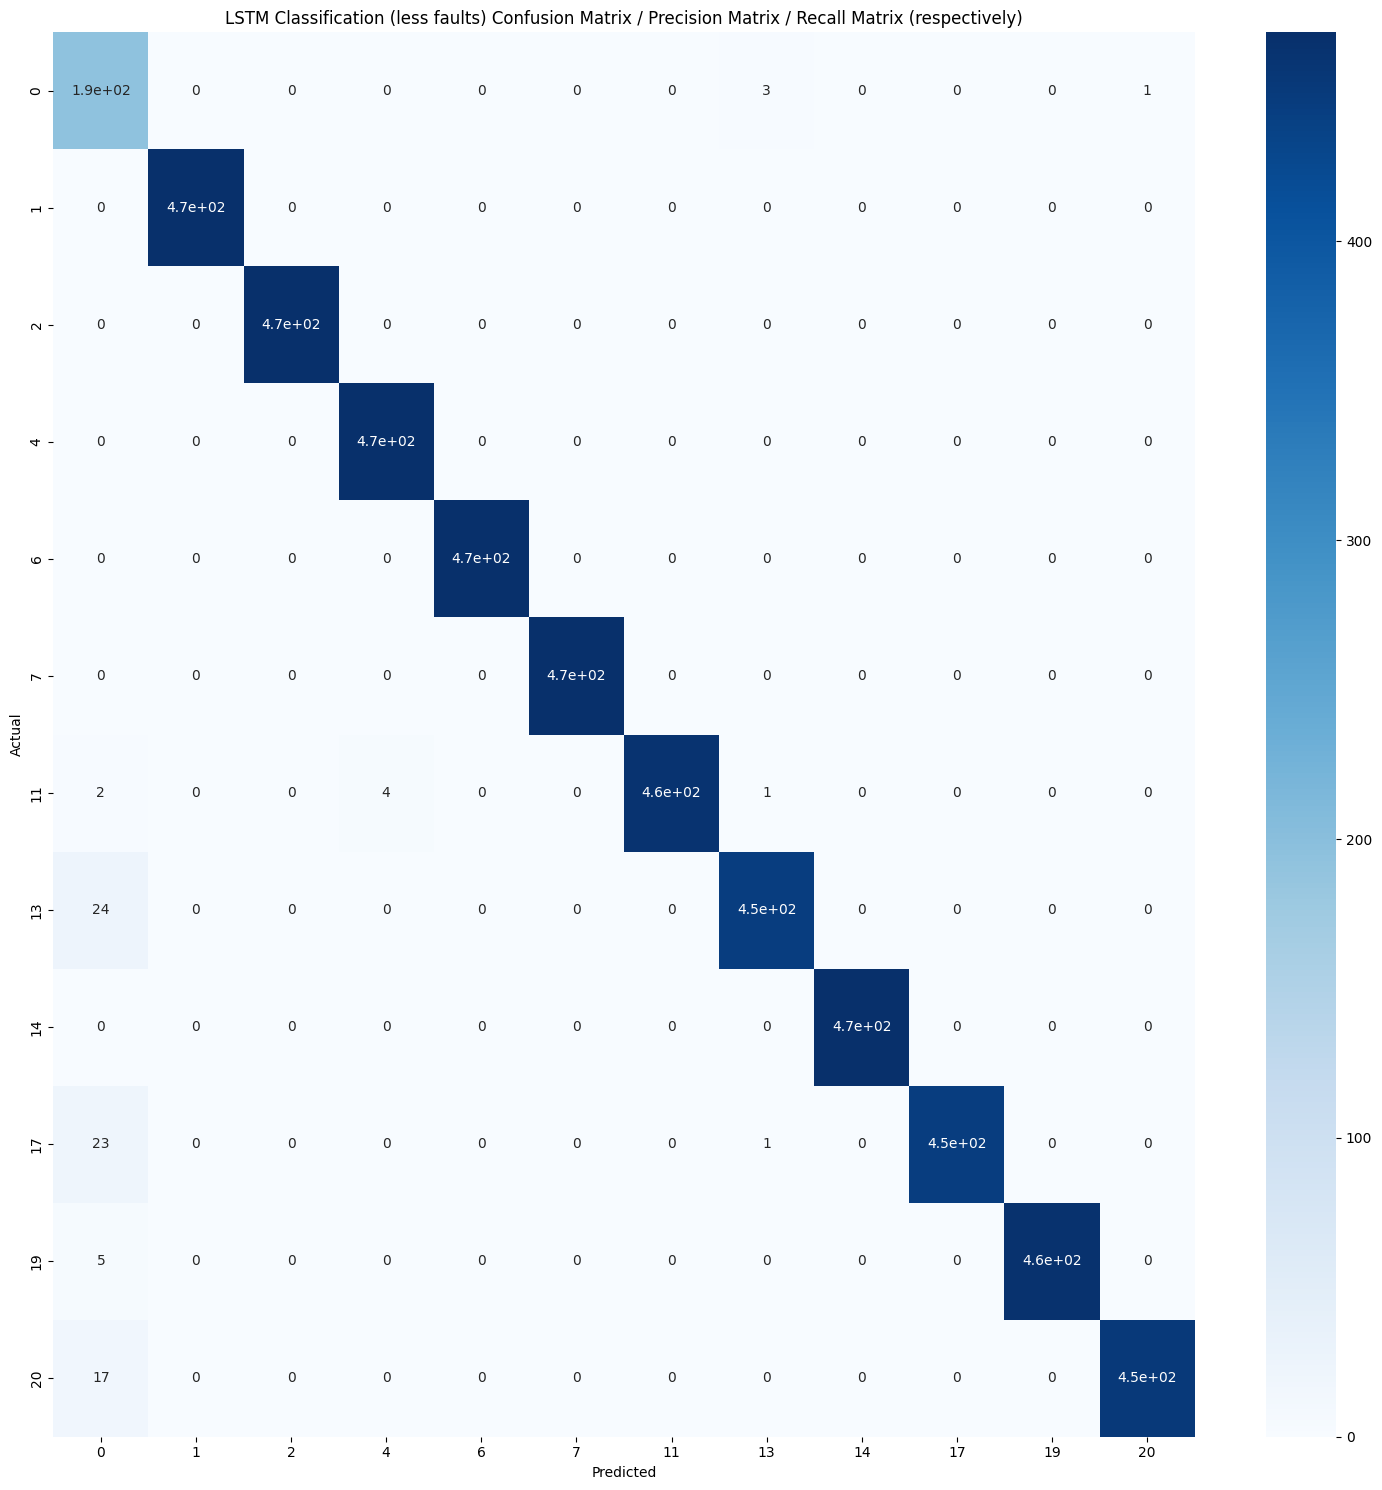

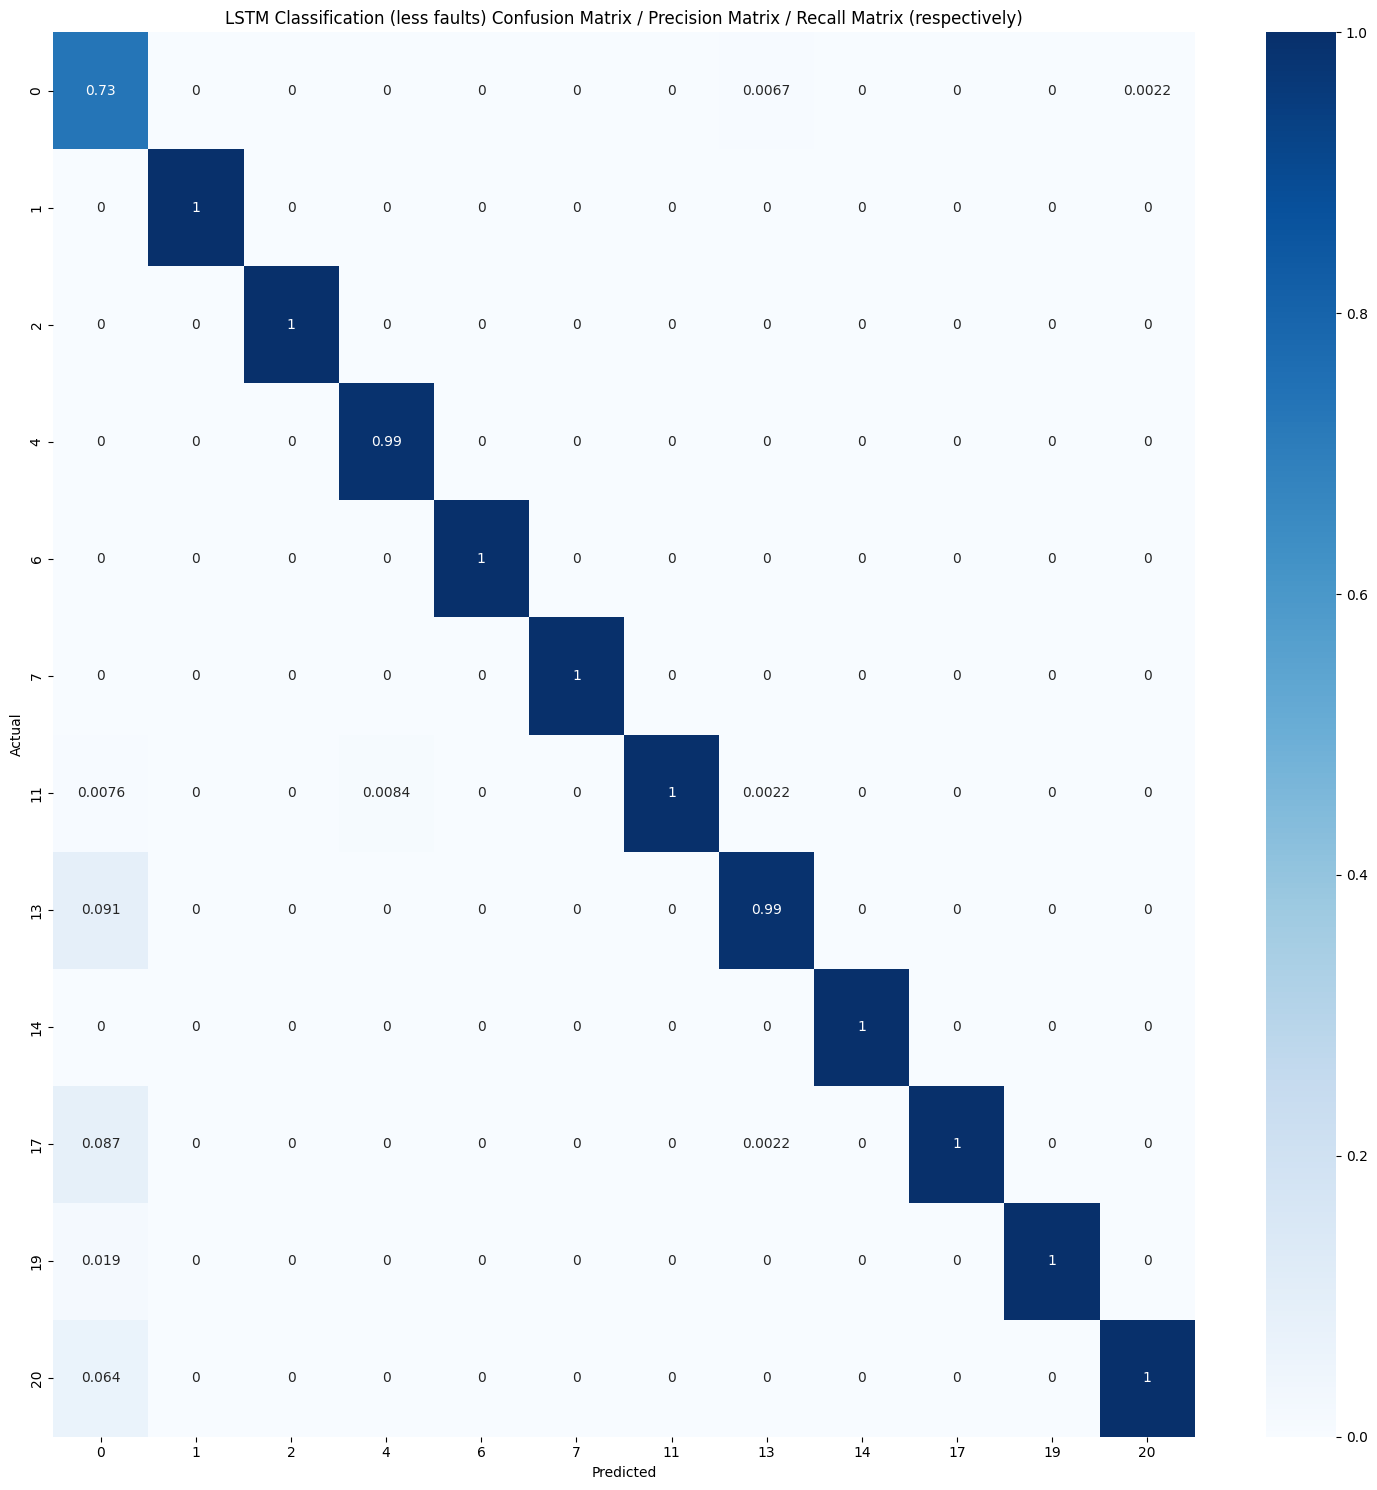

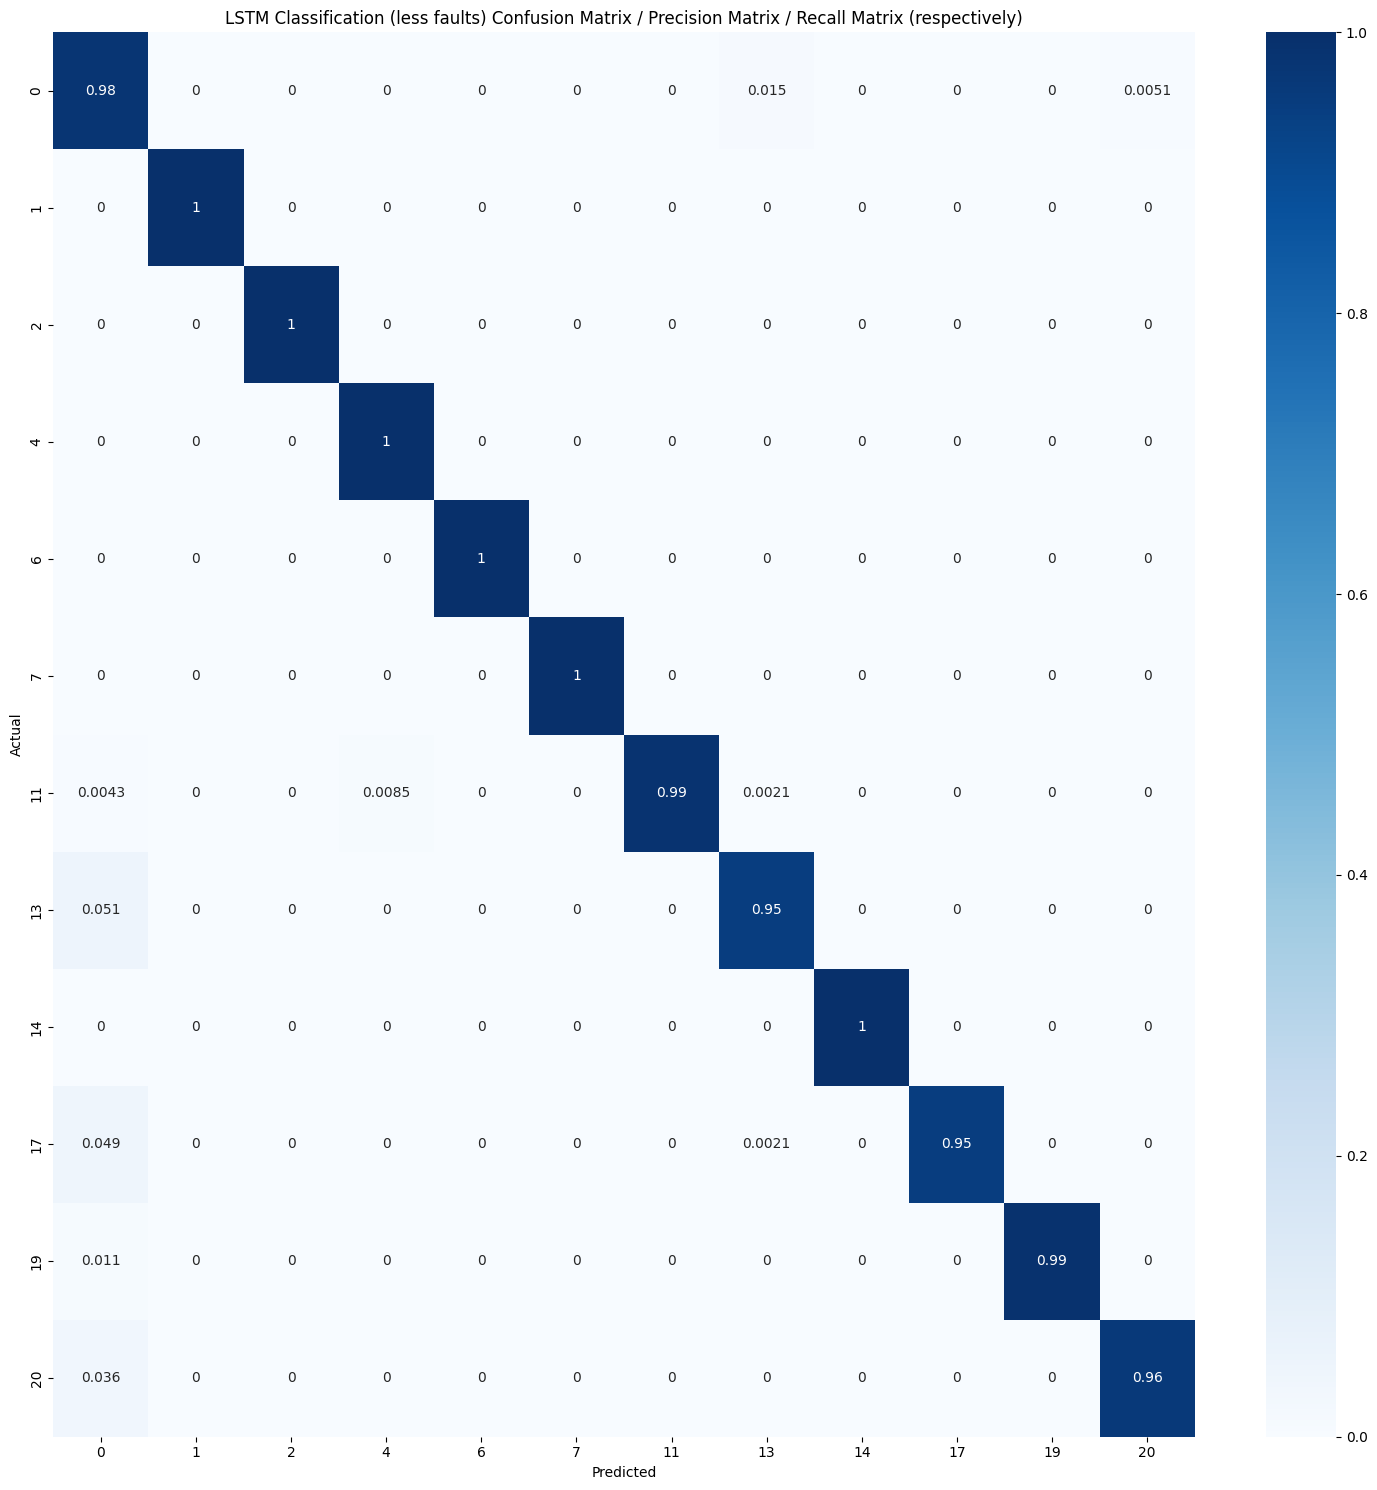

Aggregate Precision (including all classes): 0.976
Aggregate Precision (excluding class '0'): 0.998
LSTM Classification (less faults) accuracy_score: 0.9849077697037452


In [ ]:
plot_confusion_matrix_1(y_true, y_pred, 'LSTM Classification (less faults) Confusion Matrix / Precision Matrix / Recall Matrix (respectively)')
print("Bidirectional LSTM with ANN Classification (less faults) accuracy_score:", accuracy_score(y_true, y_pred))